# Generate initial state

In [1]:
import mode_analysis_code

In [2]:
mode_analysis = mode_analysis_code.ModeAnalysis(N=127,
                                                Vtrap=(0.0, -1750.0, -2000.0),
                                                Vwall=5.0,
                                                frot=180.0)

In [3]:
mode_analysis.run()

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

## Axial energy eigenvalues

In [5]:
mode_analysis.axialEvals

array([ 0.87215906,  0.87374165,  0.87548212,  0.87798673,  0.87929756,
        0.8813548 ,  0.88258589,  0.88291916,  0.88399384,  0.88598965,
        0.88693813,  0.88741521,  0.88784965,  0.88802443,  0.89055455,
        0.89136936,  0.8920383 ,  0.89289426,  0.89359424,  0.8941272 ,
        0.89517025,  0.89626294,  0.89733953,  0.89858178,  0.89892887,
        0.90056222,  0.90146457,  0.90191517,  0.90426897,  0.90481712,
        0.90550436,  0.90613356,  0.9064349 ,  0.90765002,  0.90775   ,
        0.90813093,  0.9087932 ,  0.90942767,  0.90988873,  0.91081518,
        0.91180497,  0.91273414,  0.91406997,  0.91444912,  0.91492902,
        0.9157386 ,  0.91811827,  0.91858242,  0.91922489,  0.92002369,
        0.92139104,  0.92245377,  0.92315106,  0.92511617,  0.92569429,
        0.92612424,  0.92674954,  0.92686291,  0.9275808 ,  0.9279142 ,
        0.92838748,  0.92900369,  0.92982879,  0.93013826,  0.93138314,
        0.9316958 ,  0.93229067,  0.93287497,  0.93388946,  0.93

<IPython.core.display.Javascript object>


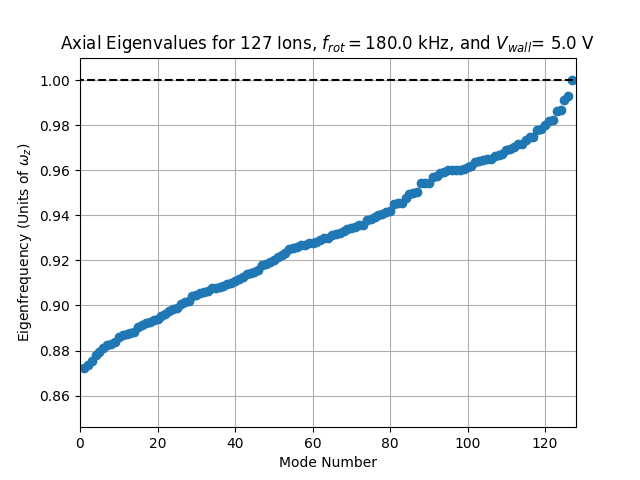

In [6]:
mode_analysis.show_axial_Evals();

# Units

Most calcualtions are done in a dimensionless system of units. Conversion to dimensionless and experimental form are done with the following two methods:

```
    def dimensionless(self):
        """Calculate characteristic quantities and convert to a dimensionless
        system
        """
        # characteristic length
        self.l0 = ((self.k_e * self.q ** 2) / (.5 * self.m_Be * self.wz ** 2)) ** (1 / 3)
        self.t0 = 1 / self.wz  # characteristic time
        self.v0 = self.l0 / self.t0  # characteristic velocity
        self.E0 = 0.5*self.m_Be*(self.wz**2)*self.l0**2 # characteristic energy
        self.wr = self.wrot / self.wz  # dimensionless rotation
        self.wc = self.wcyc / self.wz  # dimensionless cyclotron
        self.md = self.m / self.m_Be  # dimensionless mass

    def expUnits(self):
        """Convert dimensionless outputs to experimental units"""
        self.u0E = self.l0 * self.u0  # Seed lattice
        self.uE = self.l0 * self.u  # Equilibrium positions
        self.axialEvalsE = self.wz * self.axialEvals
        self.planarEvalsE = self.wz * self.planarEvals
        # eigenvectors are dimensionless anyway
```

Apparently the characteristic length is
$
l_0 = \left(\frac{q^2}{4\pi\epsilon_0}/(m \omega_z^2/2)\right)^{1/3}
$
Not quite sure what the meaning of this length scale is.


## Trap potential

The `ModeAnalysis.__init__()` method takes a parameter `Vtrap` that specifies the electrostatic potentials as far as I can tell. A comment in the source code suggests that the three components of this vector are the voltages on the end, middle, and center trap electrodes. Presumably these are in Volts. Inside `__init__()` we then calculate 0th, first, second, and fourth order moments of the trap potential at the center of the trap from the voltages. These are compute using a 4x3 matrix that is explained in "Teale's final paper". The result is stored in `self.Coeff`. The axial trap frequency is computed from this as follows:
$$
\omega_z=\sqrt{2 q {\tt self.Coeff[2]} / m}
$$
So this suggests that `self.Coeff[2]` corresponds to what I've been calling $k_z$.

A "wall potential" of $V_{\rm wall}=5$ is translated into a coefficient ${\tt self.Cw2} = q V_{\rm wall} 1612$. Apparently this is not used anymore. Instead, we use the parameter ${\tt self.Cw} = 1612 V_{\rm wall} / V_0$ where $V_0 = 1/2 m \omega_z^2 / q$ which really reduces to ${\tt self.Coeff[2]}$. I think this make `self.Cw` equivalent with the parameter $\delta$ I've been using up to perhaps a factor of 2 which I need to check on. The stronger axis of the trap is along $x$, the weaker axis is along $y$.

Apparently we are using a trap rotation frequency of $180 {\rm kHz}$ by default.

The default axial magnetic field is $B_z=4.4588T$.


## Positions

In [10]:
mode_analysis.Cw

0.0016876488601565158

In [11]:
mode_analysis.expUnits()

<IPython.core.display.Javascript object>


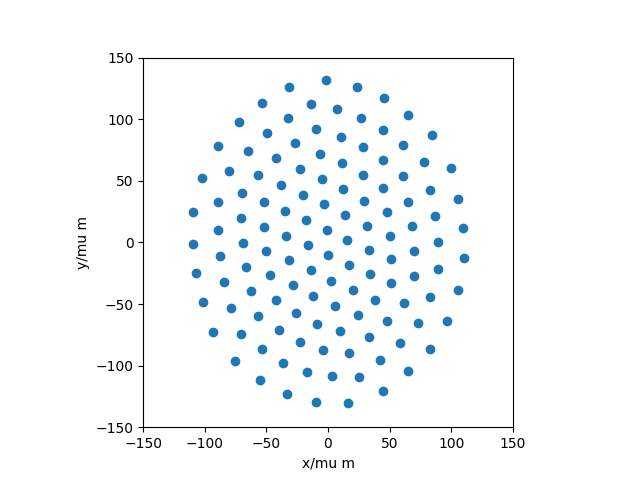

In [12]:
plt.figure()
plt.plot(1.0e6 * mode_analysis.uE[:mode_analysis.Nion], 1.0e6 * mode_analysis.uE[mode_analysis.Nion:], 'o');
plt.xlabel('x/mu m')
plt.ylabel('y/mu m')
rmax = 150.0
for l in [plt.xlim, plt.ylim]:
    l([-rmax, rmax])
plt.gca().set_aspect(1)

# parameters for simulation

In [13]:
print(mode_analysis.Cw)
print(mode_analysis.wrot)
print(mode_analysis.Coeff)
print(mode_analysis.wz)
print(mode_analysis.m_Be)
print(mode_analysis.q)
print(mode_analysis.B)
print(2.0 * np.pi / mode_analysis.wcyc)

0.00168764886016
1130973.3552923256
[ -1.71987500e+03  -1.25000000e+00   4.77587500e+06   1.89000000e+08]
10112373.2322
1.496535906374e-26
1.602176565e-19
4.4588
1.3162507819470977e-07


# Simulation

In [14]:
import coldatoms

 ## Building the ensemble
 
 First we need to construct the initial state of the ions.

In [15]:
def create_ensemble(uE, omega_z, mass, charge):
    num_ions = int(uE.size / 2)
    x = uE[:num_ions]
    y = uE[num_ions:]
    r = np.sqrt(x**2 + y**2)
    r_hat = np.transpose(np.array([x / r, y / r]))
    phi_hat = np.transpose(np.array([-y / r, x / r]))
    v = omega_z * (r[:, np.newaxis] * phi_hat)
    
    ensemble = coldatoms.Ensemble(num_ions)
    ensemble.x[:, 0] = np.copy(x)
    ensemble.x[:, 1] = np.copy(y)
    ensemble.x[:, 2] = np.zeros(num_ions)
    ensemble.v[:, 0] = np.copy(v[:, 0])
    ensemble.v[:, 1] = np.copy(v[:, 1])
    ensemble.v[:, 2] = np.zeros(num_ions)
    
    ensemble.ensemble_properties['mass'] = mass
    ensemble.ensemble_properties['charge'] = charge
    
    return ensemble

## Forces

In [16]:
coulomb_force = coldatoms.CoulombForce()

In [17]:
class TrapPotential(object):

    def __init__(self, kz, delta, omega, phi_0):
        self.kz = kz
        self.kx = -(0.5 + delta) * kz
        self.ky = -(0.5 - delta) * kz
        self.phi_0 = phi_0
        self.phi = phi_0
        self.omega = omega

    def reset_phase(self):
        self.phi = self.phi_0
            
    def force(self, dt, ensemble, f):
        self.phi += self.omega * 0.5 * dt
        
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')

        cphi = np.cos(self.phi)
        sphi = np.sin(self.phi)
        kx = self.kx
        ky = self.ky
        
        x = ensemble.x[:, 0]
        y = ensemble.x[:, 1]
        z = ensemble.x[:, 2]
        
        f[:, 0] += dt * q * (
            (-kx * cphi * cphi - ky * sphi * sphi) * x + cphi * sphi * (ky - kx) * y)
        f[:, 1] += dt * q * (
            cphi * sphi * (ky - kx) * x + (-kx * sphi * sphi - ky * cphi * cphi) * y)
        f[:, 2] += -dt * q *self.kz * z

        self.phi += self.omega * 0.5 * dt

In [18]:
trap_potential = TrapPotential(mode_analysis.Coeff[2], mode_analysis.Cw, mode_analysis.wrot, np.pi / 2.0)

In [19]:
def evolve_ensemble(dt, t_max, ensemble, Bz, forces):
    t = 0.0e0
    while t < t_max - dt:
        coldatoms.bend_kick(dt, Bz, ensemble, forces)
        t += dt
    coldatoms.bend_kick(t_max - t, Bz, ensemble, forces)

<IPython.core.display.Javascript object>


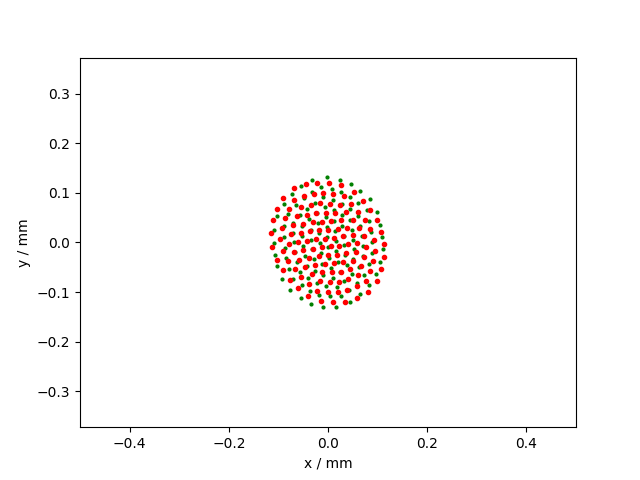

In [21]:
my_ensemble = create_ensemble(mode_analysis.uE,
                              mode_analysis.wrot,
                              mode_analysis.m_Be,
                              mode_analysis.q)
x_0 = np.copy(my_ensemble.x[:, 0])
y_0 = np.copy(my_ensemble.x[:, 1])

trap_potential.phi = np.pi / 2.0

evolve_ensemble(1.0e-9, 1.0e-6, my_ensemble, mode_analysis.B, [coulomb_force, trap_potential])

plt.figure()
plt.plot(1.0e3 * x_0, 1.0e3 * y_0, 'go', ms=2)
plt.plot(1.0e3 * my_ensemble.x[:,0], 1.0e3 * my_ensemble.x[:,1], 'ro', ms=3)
plt.xlabel('x / mm')
plt.ylabel('y / mm')
x_max = 0.5e0
y_max = x_max
plt.xlim([-x_max, x_max])
plt.ylim([-y_max, y_max])
plt.axes().set_aspect('equal', 'datalim')

<IPython.core.display.Javascript object>


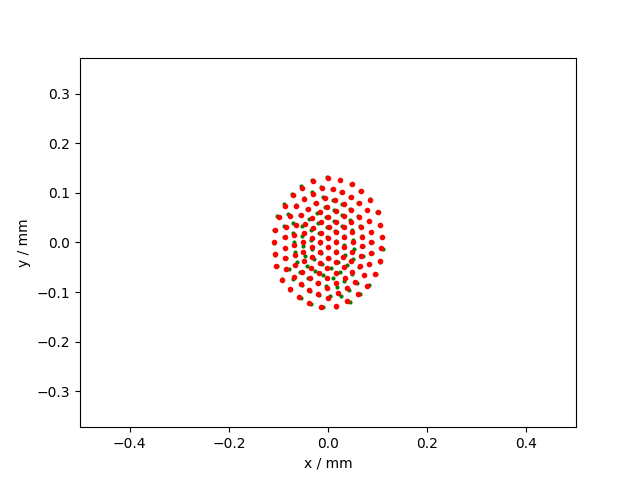

In [22]:
my_ensemble = create_ensemble(mode_analysis.uE,
                              mode_analysis.wrot,
                              mode_analysis.m_Be,
                              mode_analysis.q)
x_0 = np.copy(my_ensemble.x[:, 0])
y_0 = np.copy(my_ensemble.x[:, 1])

trap_potential.phi = np.pi / 2.0

evolve_ensemble(1.0e-9, 2.0 * np.pi / mode_analysis.wrot, my_ensemble, mode_analysis.B, [coulomb_force, trap_potential])

plt.figure()
plt.plot(1.0e3 * x_0, 1.0e3 * y_0, 'go', ms=2)
plt.plot(1.0e3 * my_ensemble.x[:,0], 1.0e3 * my_ensemble.x[:,1], 'ro', ms=3)
plt.xlabel('x / mm')
plt.ylabel('y / mm')
x_max = 0.5e0
y_max = x_max
plt.xlim([-x_max, x_max])
plt.ylim([-y_max, y_max])
plt.axes().set_aspect('equal', 'datalim')

<IPython.core.display.Javascript object>


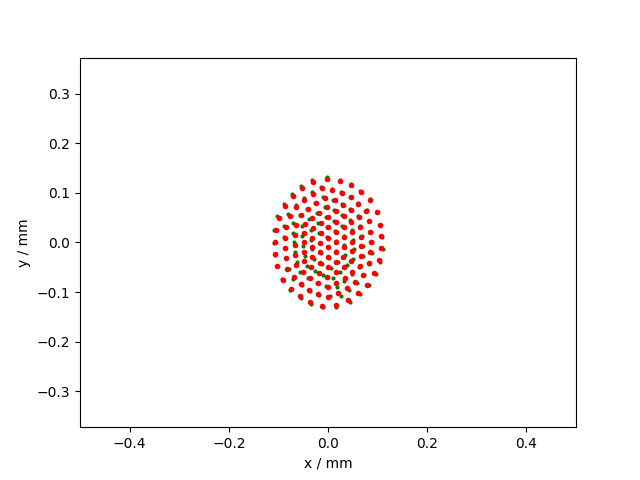

In [23]:
evolve_ensemble(1.0e-9, 5.0e-8, my_ensemble, mode_analysis.B, [coulomb_force, trap_potential])

plt.figure()
plt.plot(1.0e3 * x_0, 1.0e3 * y_0, 'go', ms=2)
plt.plot(1.0e3 * my_ensemble.x[:,0], 1.0e3 * my_ensemble.x[:,1], 'ro', ms=3)
plt.xlabel('x / mm')
plt.ylabel('y / mm')
x_max = 0.5e0
y_max = x_max
plt.xlim([-x_max, x_max])
plt.ylim([-y_max, y_max])
plt.axes().set_aspect('equal', 'datalim')

In [46]:
import json
import ast

In [36]:
def ensemble_to_json(ensemble):
    serialized = {}
    serialized['x'] = json.dumps(ensemble.x.tolist())
    serialized['v'] = json.dumps(ensemble.v.tolist())
    serialized['ensemble_properties'] = json.dumps(ensemble.ensemble_properties)
    particle_properties = {}
    for prop,val in ensemble.particle_properties.items():
        particle_properties[prop] = json.dumps(val.tolist())
    serialized['particle_properties'] = particle_properties
    return json.dumps(serialized)

In [37]:
ensemble_to_json(my_ensemble)

'{"particle_properties": {}, "v": "[[-15.767561185462421, 8.711842069676372, 0.0], [-0.7454011264058826, 4.089610201882266, 0.0], [-18.441133676794315, -12.85015681101018, 0.0], [-24.17306438910167, 23.968022966380335, 0.0], [-10.774719479234466, 15.07819641575598, 0.0], [4.490883186122779, 10.041414208326703, 0.0], [-12.841767858924069, 36.508750535666486, 0.0], [-37.34193354102725, -5.180440294548892, 0.0], [1.11343417854881, -4.158048460430494, 0.0], [-38.086642704730444, -30.706883138315067, 0.0], [-32.09366619993275, -22.453089418374972, 0.0], [-18.637820606481846, 30.224606758635105, 0.0], [-19.05501892718374, 17.26089615895668, 0.0], [13.375566633602025, -23.556046961106038, 0.0], [12.403088197698182, 7.707459184778935, 0.0], [33.381033414386515, 18.080511460571405, 0.0], [27.155891908110515, -19.721192468282297, 0.0], [30.766775160010038, -4.323379653188675, 0.0], [20.5614291403975, 5.731332686753366, 0.0], [-2.4656327896130037, -18.661618129998377, 0.0], [-4.379579426822083, -

In [51]:
def json_to_ensemble(s):
    d = json.loads(s)
    x = np.array(ast.literal_eval(d['x']))
    v = np.array(ast.literal_eval(d['v']))
    ensemble_properties = d['ensemble_properties']
    particle_properties = {}
    for key, val in d['particle_properties']:
        particle_properties[key] = np.array(ast.literal_eval(val))
    num_ptcls = x.shape[0]
    ensemble = coldatoms.Ensemble(num_ptcls)
    ensemble.x = x
    ensemble.v = v
    ensemble.ensemble_properties = ensemble_properties
    ensemble.particle_properties = particle_properties
    return ensemble

In [52]:
round_trip = json_to_ensemble(ensemble_to_json(my_ensemble))

(127, 3)
